# Example 8.3: Shortcut Maze
The problem caused by this kind of environmental change is illustrated by the maze example shown in Figure 8.5. Initially, the optimal path is to go around the left side of the bar- rier (upper left). After $3000$ steps, however, a shorter path is opened up along the right side, without disturb- ing the longer path (upper right). The graph shows that the regular Dyna-Q agent never switched to the shortcut. In fact, it never realized that it existed. Its model said that there was no shortcut, so the more it planned, the less likely it was to step to the right and discover it. Even with an $\epsilon$-greedy policy, it is very unlikely that an agent will take so many exploratory actions as to discover the shortcut.

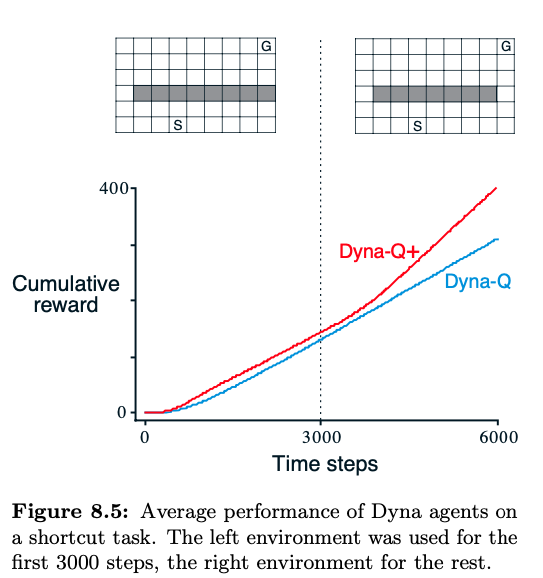

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 
from termcolor import colored
from matplotlib import colors

In [2]:
class Environment:
  def __init__(self, size, startpoint, endpoint, actions, Maze_walls):
    self.m, self.n = size
    self.actions = actions
    self.endpoint = endpoint
    self.startpoint = startpoint
    self.Maze_walls = Maze_walls
    
  def change(self):
    a, b = Maze_walls.pop()
    return (a,b)

  def step(self, position, action):
    if action not in self.actions:
      raise Error("The action (%s,%s) is not allowed!!" %action)

    reward = 0
    Done = False
    r, c = position
    a, b = action
    new_r, new_c = r-a, c+b

    if ((new_r, new_c) in self.Maze_walls 
        or new_c > self.n-1 
        or new_c < 0 
        or new_r > self.m - 1 
        or new_r < 0):
      return position, 0, False

    if (new_r, new_c) == self.endpoint:
      Done = True
      reward = 1

    return (new_r, new_c), reward, Done


In [3]:
Arrow = {}
Arrow[(0,0)] = '.'
Arrow[(0,-1)] = '\u2190' #Leftwards Arrow
Arrow[(1,0)] = '\u2191' #Upwards Arrow
Arrow[(0,1)] = '\u2192' #Rightwards Arrow
Arrow[(-1,0)] = '\u2193' #Downwards Arrow
Arrow[(1,-1)] = '\u2196' #North West Arrow
Arrow[(1,1)] = '\u2197' #North East Arrow
Arrow[(-1,1)] = '\u2198' #South East Arrow
Arrow[(-1,-1)] = '\u2199' #South West Arrow

In [4]:
class Model():
  def __init__(self, ):
    self.table = {}
  
  def initailize_table(self, table):
    self.table = table

  def update(self, s_0, a, s_1, r, Done):
    if s_0 not in self.table.keys():
      self.table[s_0] = {}
      self.table[s_0][a] = (s_1, r, Done)
    else:
      self.table[s_0][a] = (s_1, r, Done)

  def step(self):
    StateList = list(self.table.keys())
    ind = np.random.choice(range(len(StateList)))
    state = StateList[ind]

    ActionList = list(self.table[state].keys())
    ind = np.random.choice(range(len(ActionList)))
    action = ActionList[ind]
    next_state, reward, Done = self.table[state][action]

    return  state, action, next_state, reward, Done

In [5]:
class Maze:
  def __init__(self, Env, Envmodel, n_iters = 100, n_planning_steps = 0,
               gamma = 1, eps = .1, alpha = .1, Type = 'Dyna-Q', k = 0):
    
    if Type == 'Dyna-Q':
        self.Type = 'Tabular '+ Type
    elif Type == 'Dyna-Q+':
        self.Type = 'Tabular '+ Type + '\n (k = ' + str(k) +')'
    else:
        raise Error("Valid types are Dyna-Q and Dyna-Q+")
        
    self.model = Envmodel
    self.Env = Env
    self.actions = Env.actions
    self.behaiviar_policy = {}
    self.Q = {}
    self.len_episodes_hist = np.zeros(n_iters)
    self.reward_history = []
    self.last_visit_time = {}
    self.table = {}
    
    for x in range(Env.m):
      for y in range(Env.n):
        if (x,y) != Env.endpoint and (x,y) not in self.Env.Maze_walls:
          self.behaiviar_policy[(x,y)] = [1/len(Env.actions) for _ in Env.actions]
          self.Q[(x,y)] = {}
          self.table[(x,y)] = {}
          for action in Env.actions:
            self.Q[(x,y)][action] = 0
            self.last_visit_time[((x,y), action)] = 0
            self.table[(x,y)][action] = ((x,y), 0, False)
    
    if Type == 'Dyna-Q+':
        if k == 0:
            raise Warning("Dyna-Q+ with k = 0 is indeed weaker than Dyna-Q!!")
        self.model.initailize_table(self.table)
    else:
        k = 0
        
    time_step = 0 
    sum_reward = 0
    
    for x in range(1, n_iters+1):
      
      state = self.Env.startpoint
      Done = False
      epidose_len = 0
      while not Done:
        time_step += 1
        action = self.apply_behaiviar_policy(state)
        self.last_visit_time[state, action] = time_step
        next_state, reward, Done = self.Env.step(state, action)
        sum_reward += reward
        self.reward_history.append(sum_reward)
        
        if not Done:
          temp = reward + gamma * max(self.Q[next_state].values())
        else:
          temp = reward
        self.Q[state][action] = self.Q[state][action] + alpha * (temp - self.Q[state][action])
        self.update_behaiviar_policy(eps, state = state)

        self.model.update(state, action, next_state, reward, Done)
        state = next_state
        epidose_len += 1

        for j in range(n_planning_steps):
          s_0, a, s_1, r, D = self.model.step()
          if not D:
            temp = r + k * np.sqrt(time_step - self.last_visit_time[s_0, a]) + gamma * max(self.Q[s_1].values())
          else:
            temp = r + k * np.sqrt(time_step - self.last_visit_time[s_0, a])
          self.Q[s_0][a] = self.Q[s_0][a] + alpha * (temp - self.Q[s_0][a])
          self.update_behaiviar_policy(eps, state = s_0)
            
            
        if time_step == 3000:
          self.plot_optimal_policy()
          position = self.Env.change()
          self.add_state(position)
          print("Environment has been changed!!")
            
      self.len_episodes_hist[x-1] = epidose_len
      #print(x, epidose_len)
    #print(time_step)                  
    #print(colored('Ended in %s seconds', 'white', 'on_grey') %(time.time() - t))

  def add_state(self, state):
    self.behaiviar_policy[state] = [1/len(self.Env.actions) for _ in self.Env.actions]
    self.Q[state] = {}
    self.table[state] = {}
    for action in self.Env.actions:
        self.Q[state][action] = 0
        self.last_visit_time[(state, action)] = 0
        self.table[state][action] = (state, 0, False)
  
  
  def apply_behaiviar_policy(self, state):
    probabilities = self.behaiviar_policy[state]
    index = np.random.choice(range(len(self.actions)), p = probabilities)
    next_action = self.actions[index]
    return next_action
        

  def update_behaiviar_policy(self, eps, state = None):
    if state is None:
      States = self.states
    else:
      States = [state]
    for s in States:
      Max = max(self.Q[s].values())
      index = np.random.choice([x for x in range(len(self.actions))
                                if self.Q[s][self.actions[x]] >= Max])
                    
      best_action = self.actions[index]
      for idx in range(len(self.actions)):
        if best_action == self.actions[idx]:
          self.behaiviar_policy[s][idx] = 1 - eps + eps/len(self.actions)
        else:
          self.behaiviar_policy[s][idx] = eps/len(self.actions) 

  def get_optimal_policy(self):
    for state in self.behaiviar_policy.keys():
      idx = np.argmax(self.behaiviar_policy[state])
      self.target_policy[state] = self.actions[idx]

  def bulid_trajectory(self, point):
    Done = False 
    tr = []
    state = point
    while not Done:
      action = self.actions[np.argmax(self.behaiviar_policy[state])]
      tr.append((state, action))
      state, _, Done = self.Env.step(state, action)
    return tr

  def plot_optimal_policy(self):
    plt.subplots(figsize = (8, 8))
    Matrix = np.zeros((self.Env.m, self.Env.n)).astype(int)
    Matrix[self.Env.startpoint] = 1
    Matrix[self.Env.endpoint] = 2
    for pos in self.Env.Maze_walls:
      Matrix[pos] = 3
    trajectory = self.bulid_trajectory(self.Env.startpoint)
    action_trace = {}
    for i, point in enumerate(trajectory):
        action_trace[point[0]] = Arrow[point[1]]
        if point[0] != self.Env.startpoint:
          Matrix[point[0]] = -i-1
    show_annot_array = Matrix < 0
    show_annot_array[self.Env.startpoint] = True
    cmap = colors.ListedColormap(['green','white','blue','red' ,'gray'])
    bounds=[-100, -0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = sns.heatmap(Matrix, cmap=cmap, annot=True, annot_kws={"size":15},
                      linewidth=0.1, linecolor ='black', xticklabels=False, 
                      yticklabels=False, norm = norm, cbar= False, square = True)
    fig.set_title("Optimal Policy: " + self.Type, fontsize=25)
    for text, position in zip(fig.texts, ((u,v) for u in range(self.Env.m) for v in range(self.Env.n))):
        if self.Env.startpoint == position:
          text.set_text(str(action_trace[position])+'\n Start')
        elif show_annot_array[position] == True:
          text.set_text(str(action_trace[position])+'\n '+ str(np.abs(Matrix[position])))
        elif self.Env.endpoint == position:
          text.set_text('Goal')
          show_annot_array[position] = True

        text.set_visible(show_annot_array[position])
    
    plt.show()
    plt.close()    

### Optimal policies using Dyna-Q 

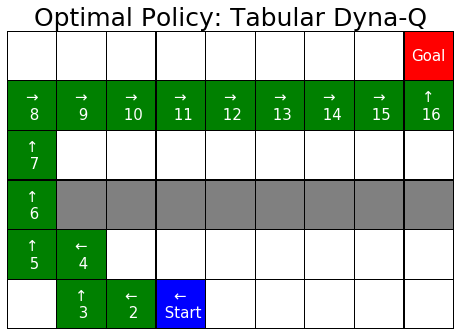

Environment has been changed!!
Final optimal policy for the new environment


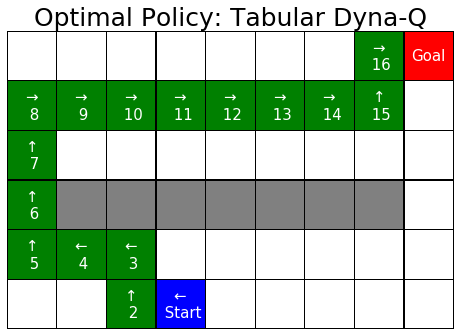

In [6]:
model1 = Model()
actions=[(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8)]
Env1 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                 actions = actions, Maze_walls = Maze_walls)
result_1 = Maze(Env = Env1, Envmodel = model1, eps = .1, gamma= .95, 
              n_iters = 300, n_planning_steps = 50)
print(colored('Final optimal policy for the new environment', 'blue'))
result_1.plot_optimal_policy()

### Optimal policies using Dyna-Q+

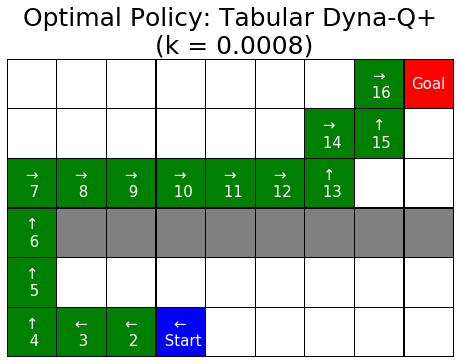

Environment has been changed!!
Final optimal policy for the new environment


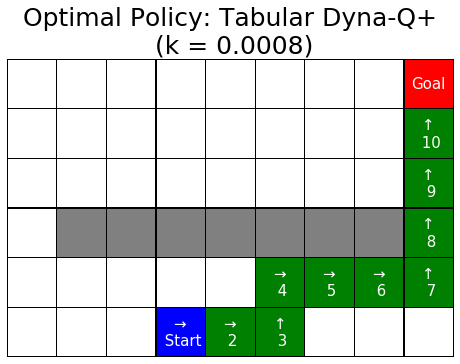

In [7]:
model2 = Model()
actions = [(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8)]
Env2 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                 actions = actions, Maze_walls = Maze_walls)
result_2 = Maze(Env = Env2, Envmodel = model2, eps = 0, gamma= .95, 
              n_iters = 350, n_planning_steps = 50, Type = 'Dyna-Q+', k = 0.0008)
print(colored('Final optimal policy for the new environment', 'blue'))
result_2.plot_optimal_policy()

### Average performance of Dyna-Q agent vs Dyna-Q+ agent  on a shortcut task.

The left environment was used for the first 3000 steps, the right environment for the rest.

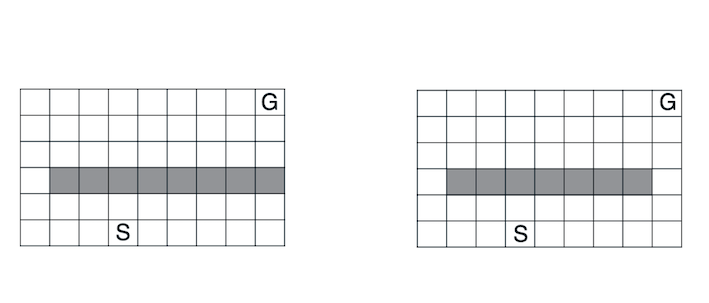

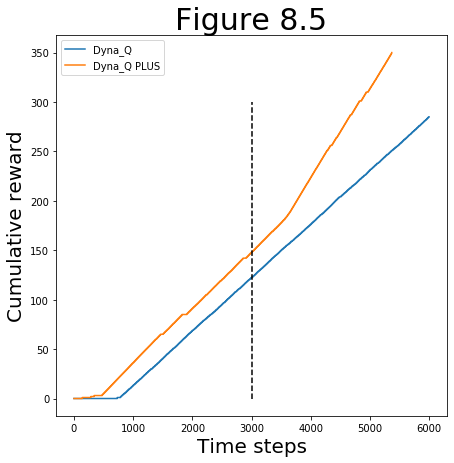

In [8]:
plt.subplots(figsize=(7, 7))


plt.plot(result_1.reward_history[:6000], label = 'Dyna_Q')
plt.plot(result_2.reward_history[:6000], label = 'Dyna_Q PLUS')

plt.plot([3000, 3000], [0, 300], 'k--')


plt.xlabel('Time steps', fontsize=20)
plt.ylabel('Cumulative reward', fontsize=20)
plt.title('Figure 8.5', fontsize=30)
plt.legend()
plt.show()